In [9]:
from array import array
import itertools
import time
import math

import sys
#####For NERSC:####
#sys.path.insert(0,'/usr/common/software/rootpy/')
import root_numpy
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

#import astroML.plotting as aml
#import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root
import ROOT
from ROOT import TH1D
from ROOT import SetOwnership
from matplotlib.ticker import NullFormatter
from ROOT import TLatex
%matplotlib inline                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Welcome to JupyROOT 6.14/04


In [10]:
Shower = "NN"
#Shower = "LO"
CorrectedP = True     #FALSE FOR HARDPROBES

if (Shower == "NN"):
    pPb_File = 'InputData/13def_SE_GMB_new_Ratio.root'
    pp_File = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
    if (CorrectedP):
        purity = 0.2615
    else:
        purity = 0.352546
if (Shower == "LO"):
    pPb_File = 'InputData/13def_SE_L0_Correlation_GMB_Ratio.root'
    pp_File = 'InputData/17q_SE_L0_Correlation_GMB_Ratio.root'
    if (CorrectedP):
        purity = 0.221083
    else:
        purity = 0.271083
        
print purity
        
#pPb_File = 'InputData/13def_EMax_SE_GMB_Ratio.root'
#pp_File = 'InputData/17q_SE_EMax_Correlation_GMB_Ratio.root'

MC_File = 'InputData/18b10a_pthat_1_2_SE_NN_Correlation_GMB_Ratio.root'

0.2615


In [11]:
#delta_phi_centers= np.array([0.19634954084936207, 0.5890486225480862, 0.9817477042468103, 1.3744467859455345, 1.7671458676442586, 2.1598449493429825, 2.552544031041707, 2.945243112740431])

####Ommiting first dphi bin######
delta_phi_centers= np.array([0.5890486225480862, 0.9817477042468103, 1.3744467859455345, 1.7671458676442586, 2.1598449493429825, 2.552544031041707, 2.945243112740431])
phi_width = [0.39269908169872414/2]*len(delta_phi_centers)

###Array used for UE Error bar####
ue_error_bar = np.array([0,0.05,0.1,0.15,0.2,0.25,0.3,0.39269908169872414,2*0.39269908169872414])

zTbins = [0.05, 0.07670637, 0.11767734, 0.18053204, 0.27695915, 0.42489062, 0.65183634, 1]
pTbins = [0,0,12, 15]

#####. Total Number of zT bins, max 7  #####
NzT = 4

#####  Skip First N zT bins  #####
zT_offset = 2

zT_centers = np.zeros(NzT)
zT_widths = np.zeros(NzT)
for ztbin in range(zT_offset,NzT+zT_offset):
    zT_centers[ztbin-zT_offset] = (zTbins[ztbin]+ zTbins[ztbin+1])/2
    zT_widths[ztbin-zT_offset] = (zTbins[ztbin+1]-zTbins[ztbin])/2

Corrections = [1,1.007,0.982,0.970,0.942,0.830,0.640]
oneminFake = [1,0.982,0.980,0.978,0.970,0.915,0.812]

In [7]:
def Get_NTriggers(filename,ipt, Signal_DNN=True): 
    file = ROOT.TFile(filename)
    if (Signal_DNN == "Inclusive"):
        ntrig_histo = file.Get('N_Triggers_pT%1.0f_%1.0f' %(pTbins[ipt],pTbins[ipt+1]))
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN))
        ntrig_histo = file.Get('N_DNN%i_Triggers_pT%1.0f_%1.0f' %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1]))
    NTriggers = 1
    if not(ntrig_histo == None):
        NTriggers = ntrig_histo.GetEntries()
    file.Close()
    return NTriggers

In [10]:
def GetEtaProj(filename,prfx,ipt, izt, Signal_DNN=True):
    
    file = ROOT.TFile(filename)

    N_Eta_Bins = 14
    
    if (Signal_DNN == "Inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        EtaProjection = histo2D.ProjectionY('Inclusive_EtaProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),0,-1)
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        EtaProjection = histo2D.ProjectionY('DNN%i_EtaProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),0,-1)
    
    EtaProjection.SetDirectory(0)
    #EtaProjection.Scale(1.0/1.2)
    
    #per trigger yield
    ntriggers = Get_NTriggers(filename,ipt, Signal_DNN)
    if not(ntriggers == None):
        EtaProjection.Scale(1.0/ntriggers)
    
    file.Close()
    
    return EtaProjection

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv_phi
Info in <TCanvas::Print>: png file pics/Eta_Same_Mix_Projections_Trigger_pt_2.png has been created


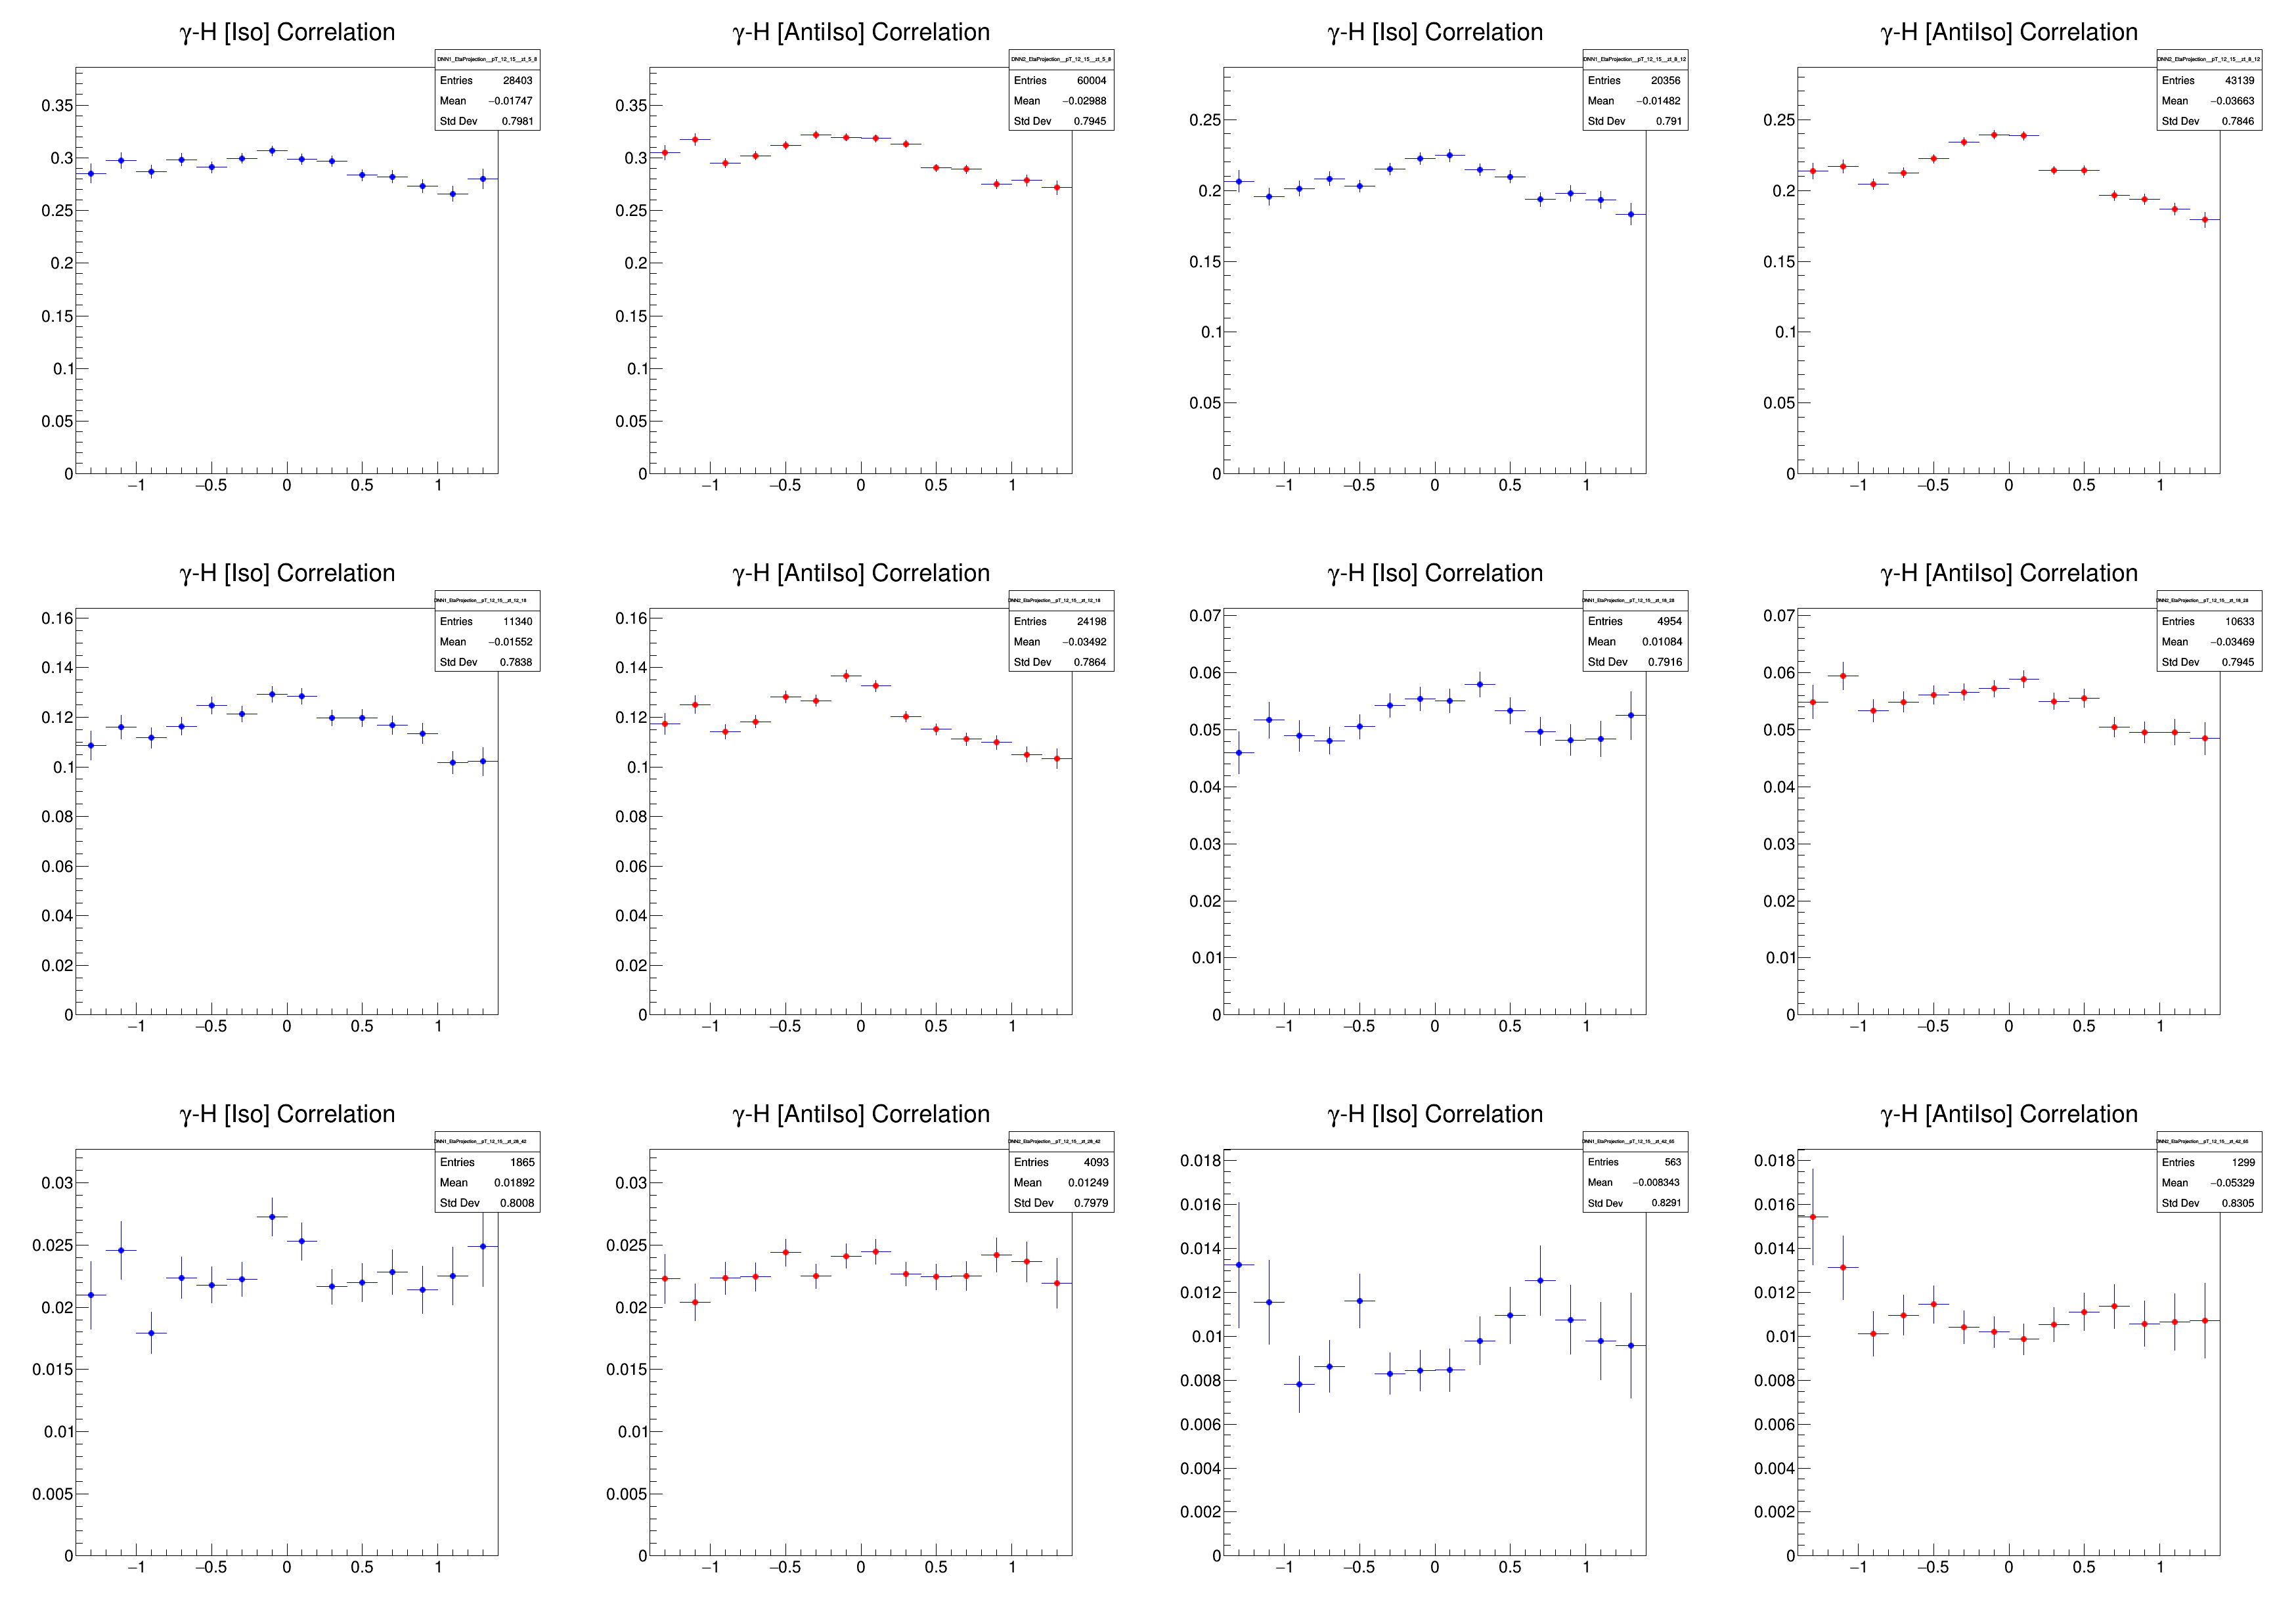

In [24]:
for ptbin in range(3):
    if(ptbin > 0): continue
    ptbin = ptbin+2
    canvases = ROOT.TCanvas("canv_phi","canv_phi",3500,2500)
    canvases.Divide(4,3)
    
    for ztbin in range(6):
    
        #grab
        hsig = GetEtaProj(pp_File,"pp",ptbin,ztbin,True) #no subtraction, change DNN
        hbkg = GetEtaProj(pp_File,"pp",ptbin,ztbin,False)
 
        #same scale
        ymax = 1.2*max(hsig.GetMaximum(),hbkg.GetMaximum())
        hsig.GetYaxis().SetRangeUser(0,ymax)
        hbkg.GetYaxis().SetRangeUser(0,ymax)    
    
        #Signal
        canvases.cd(ztbin*2+1)
        hsig.SetMarkerStyle(15)
        #hsig.SetMarkerSize(4)
        hsig.SetMarkerColor(4)
        hsig.Draw()
        
        #Background
        canvases.cd(ztbin*2+2)
        hbkg.SetMarkerStyle(15)
        #hbkg.SetMarkerSize(4)
        hbkg.SetMarkerColor(2)
        hbkg.Draw()
        #legend.AddEntry(hbkg,"Low DNN","l")
        #legend.Draw("same")
    
    canvases.Draw()   
    canvases.SaveAs("pics/Eta_Same_Mix_Projections_Trigger_pt_%i.png"%(ptbin))

# Numbers of Pairs in zT bins

In [13]:
Shower = "NN"
Low_pT_Files = ['InputData/17q_SE_NN_Correlation_GMB_Ratio.root','InputData/13def_SE_GMB_new_Ratio.root']
Low_pT_Bins = [12,15]
High_pT_Files = ['InputData/17q_SE_NN_Correlatios_GMB_Ratio_HighpT.root','InputData/13def_SE_NN_Correlatios_GMB_Ratio_HighpT.root']
High_pT_Bins = [15,20]

zTbins = [0.05, 0.07670637, 0.11767734, 0.18053204, 0.27695915, 0.42489062, 0.65183634, 1]
#####. Total Number of zT bins, max 7  #####
NzT = 4
#####  Skip First N zT bins  #####
zT_offset = 2


In [38]:
def GetCorrelation_Npairs(filename,pt_min,pt_max, izt, Signal_DNN=True):
    
    file = ROOT.TFile(filename)
    
    if (Signal_DNN == "Inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pt_min[ipt],pt_max,100*zTbins[izt],100*zTbins[izt+1]))
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pt_min,pt_max,100*zTbins[izt],100*zTbins[izt+1]))
        
    N_Pairs = histo2D.GetEntries()
    return N_Pairs

In [39]:
GetCorrelation_Npairs(High_pT_Files[0],High_pT_Bins[0],High_pT_Bins[1],2,True)

2089.2822588654376

In [52]:
low_pp = []
high_pp = []
low_pPb = []
high_pPb = []
ztstring = []
for izt in range (zT_offset,NzT+zT_offset):
    ztb = izt-zT_offset
    ztstring.append("%1.2f-%1.2f"%(zTbins[izt],zTbins[izt+1]))
    low_pp.append(GetCorrelation_Npairs('InputData/17q_SE_NN_Correlation.root',12,15,izt,True))
    high_pp.append(GetCorrelation_Npairs('InputData/17q_SE_NN_Correlation_HighpT.root',15,20,izt,True))
    low_pPb.append(GetCorrelation_Npairs('InputData/13def_SE_NN_Correlation.root',12,15,izt,True))
    high_pPb.append(GetCorrelation_Npairs('InputData/13def_SE_NN_Correlation_HighpT.root',15,20,izt,True))

print(ztstring)
print(low_pp)
print(high_pp)
print(low_pPb)
print(high_pPb)

['0.12-0.18', '0.18-0.28', '0.28-0.42', '0.42-0.65']
[12078.0, 5385.0, 2258.0, 772.0]
[3706.0, 1541.0, 701.0, 291.0]
[46962.0, 18297.0, 5569.0, 1608.0]
[12992.0, 4604.0, 1487.0, 471.0]
